<a href="https://www.kaggle.com/code/devansh158/banned-product-classifier?scriptVersionId=282710712" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Banned Product Image Classifier — Updated Notebook

This notebook trains a binary image classifier (banned vs allowed) using transfer learning (EfficientNetB0).
It includes:
- Cell 1: environment fix (protobuf pin) + diagnostics
- Explicit train/val loading (prevents leakage)
- Data pipeline with augmentation, MirroredStrategy, class weights
- Safer training (native .keras checkpoint) and fine-tuning
- Evaluation and inference helper

**Before running**
1. Attach your dataset to the Notebook so it is available at:
   `/kaggle/input/<your-dataset>/dataset` or upload to `/kaggle/working/dataset`.
2. Dataset layout expected:
```
dataset/
  train/
    positive/
    negative/
  val/
    positive/
    negative/
  (optional) test/
```
3. Enable GPU in Notebook Settings.
4. Run cells sequentially. If Cell 1 changes protobuf, restart the session and re-run Cell 1.


In [1]:

# Cell 1 — environment fix (protobuf) + diagnostics
print("Installing protobuf==3.20.3 (may show pip dependency warnings)...")
!pip install --quiet "protobuf==3.20.3"

import os, sys, importlib
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

try:
    import google.protobuf as _pb
    importlib.reload(_pb)
except Exception as e:
    print("Warning reloading google.protobuf:", e)

# import main libs
import math, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("\nEnvironment summary:")
print("---------------------")
print("Python:", sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)
try:
    import google.protobuf as pb; print("protobuf:", pb.__version__)
except Exception as e:
    print("protobuf import error:", e)

# GPU check
try:
    gpus = tf.config.list_physical_devices("GPU")
    print("GPUs found:", len(gpus))
    if gpus:
        from tensorflow.python.client import device_lib
        devices = device_lib.list_local_devices()
        for d in devices:
            if d.device_type in ('GPU','CPU'):
                print(" ", d.name, "|", d.device_type)
except Exception as e:
    print("GPU check error:", e)

print("\nNOTE: If you changed protobuf, restart the notebook session (Kaggle -> three dots -> Restart session) and run this cell again.")


Installing protobuf==3.20.3 (may show pip dependency warnings)...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 w

2025-11-29 19:17:50.532645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764443870.728867      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764443870.779633      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Environment summary:
---------------------
Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.18.0
protobuf: 3.20.3
GPUs found: 2
  /device:CPU:0 | CPU
  /device:GPU:0 | GPU
  /device:GPU:1 | GPU

NOTE: If you changed protobuf, restart the notebook session (Kaggle -> three dots -> Restart session) and run this cell again.


I0000 00:00:1764443886.793108      20 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764443886.793747      20 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [2]:

# Cell 2 — dataset paths (edit if needed)
import os
BASE_INPUT = "/kaggle/input"
dataset_root = None

for root, dirs, files in os.walk(BASE_INPUT):
    if 'train' in dirs and 'val' in dirs:
        dataset_root = root
        break

if dataset_root is None:
    # fallback - edit if your dataset is somewhere else
    dataset_root = "/kaggle/working/dataset"

train_dir = os.path.join(dataset_root, "train")
val_dir = os.path.join(dataset_root, "val")

print("Dataset root:", dataset_root)
print("Train dir exists:", os.path.exists(train_dir))
print("Val dir exists:  ", os.path.exists(val_dir))


Dataset root: /kaggle/input/alcohol-bottle-detection-devansh-srivastava/dataset
Train dir exists: True
Val dir exists:   True


In [3]:
# Cell 3 — parameters (updated)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32   # reduce to 16 or 8 if you hit OOM
SEED = 123
EPOCHS = 24       # increased because we lowered LR to 1e-4
AUTOTUNE = tf.data.AUTOTUNE

print("IMG_SIZE:", IMG_SIZE, "BATCH_SIZE:", BATCH_SIZE, "EPOCHS:", EPOCHS)


IMG_SIZE: (224, 224) BATCH_SIZE: 32 EPOCHS: 24


In [4]:

# Cell 4 — load datasets from explicit train/ and val/ folders
import tensorflow as tf
from collections import Counter
import os

if not (os.path.exists(train_dir) and os.path.exists(val_dir)):
    raise FileNotFoundError(f"train_dir or val_dir not found. train_dir={train_dir}, val_dir={val_dir}")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

print("Class names (train):", train_ds.class_names)
print("Class names (val):  ", val_ds.class_names)

def counts_from_ds(ds):
    cnt = Counter()
    for _, labels in ds.unbatch():
        cnt[int(labels.numpy().item())] += 1
    return cnt

print("Train counts:", counts_from_ds(train_ds))
print("Val counts:  ", counts_from_ds(val_ds))


Found 186 files belonging to 2 classes.


I0000 00:00:1764443886.960437      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764443886.960644      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 81 files belonging to 2 classes.
Class names (train): ['negative', 'positive']
Class names (val):   ['negative', 'positive']
Train counts: Counter({1: 99, 0: 87})
Val counts:   Counter({1: 42, 0: 39})


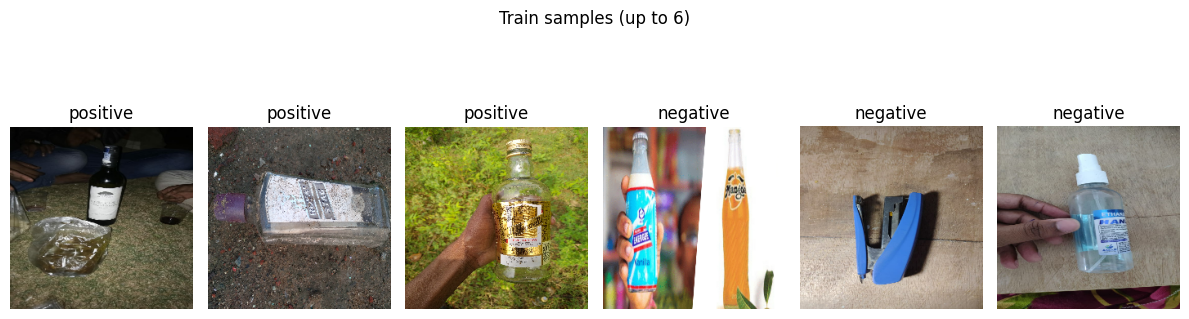

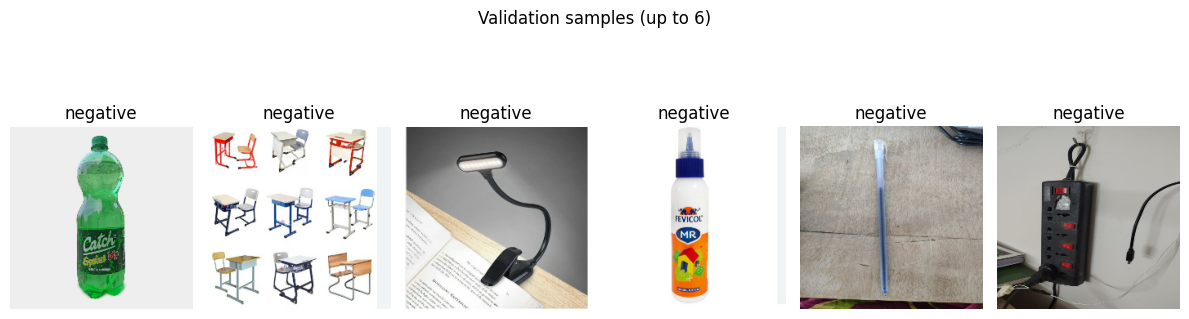

In [5]:

# Cell 5 — show sample images from train and val
import matplotlib.pyplot as plt, numpy as np

def show_samples(ds, title, n=6):
    plt.figure(figsize=(12,4))
    for images, labels in ds.take(1):
        imgs = images.numpy().astype("uint8")
        labs = labels.numpy()
        nshow = min(n, imgs.shape[0])
        for i in range(nshow):
            ax = plt.subplot(1,nshow,i+1)
            plt.imshow(imgs[i])
            lbl = int(labs[i].item()) if hasattr(labs[i],'item') else int(labs[i])
            plt.title(f"{ds.class_names[lbl]}")
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(train_ds, "Train samples (up to 6)")
show_samples(val_ds, "Validation samples (up to 6)")


In [6]:

# Cell 6 — prepare dataset pipeline (cache/prefetch)
def prepare(ds, shuffle=False):
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds)
print("Datasets prepared (cached + prefetch).")


Datasets prepared (cached + prefetch).


In [7]:

# Cell 7 — in-model data augmentation
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
], name="data_augmentation")
print("Data augmentation layer created.")


Data augmentation layer created.


In [8]:

# Cell 8 — build model with MirroredStrategy (EfficientNetB0)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

strategy = tf.distribute.MirroredStrategy()
print("Num replicas:", strategy.num_replicas_in_sync)

with strategy.scope():
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False

    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )

model.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Num replicas: 2
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:

# Cell 9 — compute class weights (warning-free)
from collections import Counter
def get_counts(dataset):
    cnt = Counter()
    for _, labels in dataset.unbatch():
        lbl = int(labels.numpy().item())
        cnt[lbl] += 1
    return cnt

counts = get_counts(train_ds)
print("Train class counts:", counts)
total = sum(counts.values())
class_weight = {cls: total / (len(counts) * cnt) for cls, cnt in counts.items()}
print("Class weights:", class_weight)


Train class counts: Counter({1: 99, 0: 87})
Class weights: {0: 1.0689655172413792, 1: 0.9393939393939394}


In [10]:
# Recompile model with smaller LR (safer for small datasets)
from tensorflow import keras
with strategy.scope():
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
print("Recompiled model with learning rate = 1e-4")

Recompiled model with learning rate = 1e-4


In [11]:

# Cell 10 — safer training (stage 1)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

checkpoint_path = "/kaggle/working/best_model.keras"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

EPOCHS_STAGE1 = EPOCHS

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

print("\nTraining finished. Best model saved to:", checkpoint_path)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/24
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 4 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size

E0000 00:00:1764443916.852276      20 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1764443920.829026      76 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764443920.829029      74 cuda_dnn.cc:529] Loaded cuDNN version 90300


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5202 - auc: 0.6020 - loss: 0.6956INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5214 - auc: 0.6013 - loss: 0.6959 - val_accuracy: 0.8750 - val_auc: 0.0000e+00 - val_loss: 0.4925 - learning_rate: 1.0000e-04
Epoch 2/24
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6587 - auc: 0.6690 - loss: 0.6416INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

Epoch 2: val_loss improved from 0.49252 to 0.49045, saving model to /kaggle/working/best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.6607 - auc: 0.6721 - loss: 0.6408 - val_accuracy: 0.8438 - val_auc: 0.0000e+00 - val_loss: 0.4904 - learning_rate: 1.0000e-04
Epoch 3/24
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6500 - auc: 0.6997 - loss: 0.6352INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0

Class names: ['negative', 'positive']
Total validation files: 81


,filepath,label
0,/kaggle/input/alcohol-bottle-detection-devansh...,0
1,/kaggle/input/alcohol-bottle-detection-devansh...,0
2,/kaggle/input/alcohol-bottle-detection-devansh...,0
3,/kaggle/input/alcohol-bottle-detection-devansh...,0
4,/kaggle/input/alcohol-bottle-detection-devansh...,0


W0000 00:00:1764443974.837124      20 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "VALID" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 225 } dim { size: 225 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12050" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multi


Counts by true label:
label
1    42
0    39
Name: count, dtype: int64

Confusion Matrix:
[[37  2]
 [ 0 42]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9487    0.9737        39
           1     0.9545    1.0000    0.9767        42

    accuracy                         0.9753        81
   macro avg     0.9773    0.9744    0.9752        81
weighted avg     0.9764    0.9753    0.9753        81

ROC AUC: 1.0
False Negatives (missed positives) — none


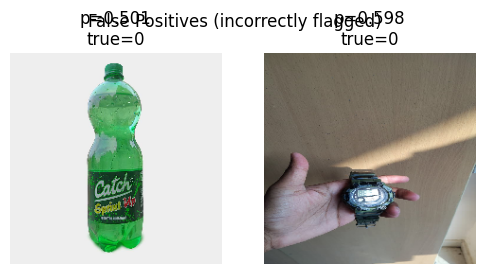


Saved predictions to /kaggle/working/val_predictions.csv


In [12]:
# Evaluation cell 
import os, numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

val_root = val_dir  # path from your earlier cell

# Get class order from folder names (sorted alphabetically)
class_names = sorted(os.listdir(train_dir))  # ['negative', 'positive']
print("Class names:", class_names)

# Gather filepaths and true labels
files = []
labels = []

for cls in class_names:
    cls_dir = os.path.join(val_root, cls)
    if not os.path.isdir(cls_dir): 
        continue
    for fname in sorted(os.listdir(cls_dir)):
        if fname.lower().endswith(('.jpg','.jpeg','.png','bmp','gif')):
            files.append(os.path.join(cls_dir, fname))
            labels.append(class_names.index(cls))  # 0 or 1

print("Total validation files:", len(files))

df = pd.DataFrame({"filepath": files, "label": labels})
display(df.head())

# Prediction helper
def predict_file(fpath, model, img_size=IMG_SIZE):
    img = image.load_img(fpath, target_size=img_size)
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, 0)
    arr = tf.keras.applications.efficientnet.preprocess_input(arr)
    prob = float(model.predict(arr, verbose=0).ravel()[0])
    return prob

# Make predictions
df['prob'] = df['filepath'].apply(lambda f: predict_file(f, model))
df['pred'] = (df['prob'] >= 0.5).astype(int)

print("\nCounts by true label:")
print(df['label'].value_counts())

# Metrics
y_true = df['label'].values
y_pred = df['pred'].values
y_prob = df['prob'].values

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

print("ROC AUC:", roc_auc_score(y_true, y_prob))

# Show misclassified images
fn = df[(df['label']==1) & (df['pred']==0)]
fp = df[(df['label']==0) & (df['pred']==1)]

def show_mis(df_sub, title, n=6):
    if df_sub.empty:
        print(title, "— none")
        return
    nshow = min(n, len(df_sub))
    plt.figure(figsize=(3*nshow, 3))
    for i, row in enumerate(df_sub.head(nshow).itertuples()):
        img = image.load_img(row.filepath, target_size=IMG_SIZE)
        arr = image.img_to_array(img).astype("uint8")
        ax = plt.subplot(1, nshow, i+1)
        plt.imshow(arr)
        plt.title(f"p={row.prob:.3f}\ntrue={row.label}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_mis(fn, "False Negatives (missed positives)")
show_mis(fp, "False Positives (incorrectly flagged)")

# Save predictions CSV
out_csv = "/kaggle/working/val_predictions.csv"
df.to_csv(out_csv, index=False)
print("\nSaved predictions to", out_csv)


In [13]:
# === Cell: Re-create datasets with drop_remainder=True and prepare pipeline ===
import os
import tensorflow as tf
from collections import Counter

print("Train dir:", train_dir)
print("Val dir:  ", val_dir)
print("BATCH_SIZE:", BATCH_SIZE, "IMG_SIZE:", IMG_SIZE)

# 1) load datasets normally first (single-image elements inside batches)
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# 2) convert to single-element stream and re-batch with drop_remainder=True
train_ds = train_ds_raw.unbatch().batch(BATCH_SIZE, drop_remainder=True)
val_ds   = val_ds_raw.unbatch().batch(BATCH_SIZE, drop_remainder=True)

# 3) prepare (cache / shuffle / prefetch)
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False):
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds, shuffle=False)

# 4) quick sanity checks
train_images = sum(1 for _ in train_ds.unbatch())
val_images = sum(1 for _ in val_ds.unbatch())
train_batches = sum(1 for _ in train_ds)
val_batches = sum(1 for _ in val_ds)

print("Train images (after re-batch):", train_images, "Train batches:", train_batches)
print("Val images   (after re-batch):", val_images,   "Val batches:  ", val_batches)

# 5) recompute class weights from train_ds (warning-free)
def get_counts(ds):
    cnt = Counter()
    for _, labels in ds.unbatch():
        cnt[int(labels.numpy().item())] += 1
    return cnt

counts = get_counts(train_ds)
print("Train class counts (recomputed):", counts)
total = sum(counts.values())
class_weight = {cls: total / (len(counts) * cnt) for cls, cnt in counts.items()}
print("Class weights:", class_weight)

# 6) quick batch-shape test
for batch_images, batch_labels in train_ds.take(1):
    print("One train batch shape:", batch_images.shape, "one labels shape:", batch_labels.shape)


Train dir: /kaggle/input/alcohol-bottle-detection-devansh-srivastava/dataset/train
Val dir:   /kaggle/input/alcohol-bottle-detection-devansh-srivastava/dataset/val
BATCH_SIZE: 32 IMG_SIZE: (224, 224)
Found 186 files belonging to 2 classes.
Found 81 files belonging to 2 classes.
Train images (after re-batch): 160 Train batches: 5
Val images   (after re-batch): 64 Val batches:   2
Train class counts (recomputed): Counter({1: 81, 0: 79})
Class weights: {0: 1.0126582278481013, 1: 0.9876543209876543}
One train batch shape: (32, 224, 224, 3) one labels shape: (32, 1)


In [14]:
# === Cell: Safe fine-tuning (recompile + unfreeze last N layers + train) ===
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Conservative number of top base layers to unfreeze
fine_tune_layers = 50   # adjust to 30-100 if you want more/less fine-tuning

# Make sure base_model exists and set trainable flags
for layer in base_model.layers[:-fine_tune_layers]:
    layer.trainable = False
for layer in base_model.layers[-fine_tune_layers:]:
    layer.trainable = True

print("Fine-tuning — trainable layers (last):", fine_tune_layers)

# Callbacks for fine-tuning
checkpoint_ft = "/kaggle/working/best_model_finetuned.keras"
callbacks_ft = [
    ModelCheckpoint(checkpoint_ft, monitor="val_loss", mode="min", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=4, mode="min", restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]

# Recompile under the distribution strategy with a very small LR
with strategy.scope():
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )

# Run fine-tuning: short number of epochs
EPOCHS_STAGE2 = 6
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks_ft,
    class_weight=class_weight,
    verbose=1
)

print("\nFine-tuning finished. Best model saved to:", checkpoint_ft)


Fine-tuning — trainable layers (last): 50
Epoch 1/6
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 49 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, n

E0000 00:00:1764444031.732575      20 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


      5/Unknown 23s 83ms/step - accuracy: 0.8784 - auc: 0.9600 - loss: 0.3744

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce te

Confusion Matrix:
 [[38  1]
 [ 0 25]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9744    0.9870        39
           1     0.9615    1.0000    0.9804        25

    accuracy                         0.9844        64
   macro avg     0.9808    0.9872    0.9837        64
weighted avg     0.9850    0.9844    0.9844        64

ROC AUC: 1.0
Average Precision (PR AUC): 1.0


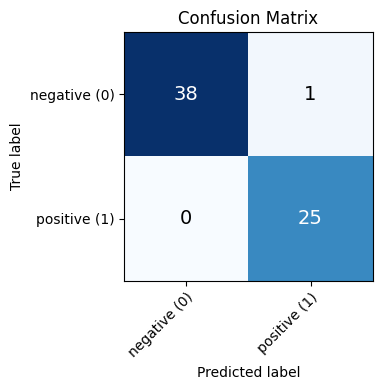

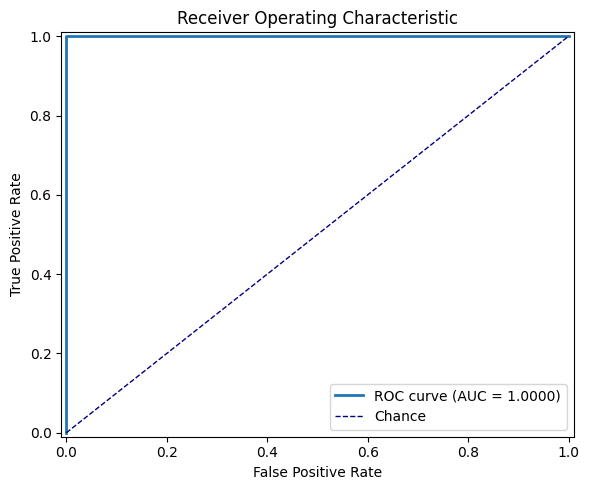

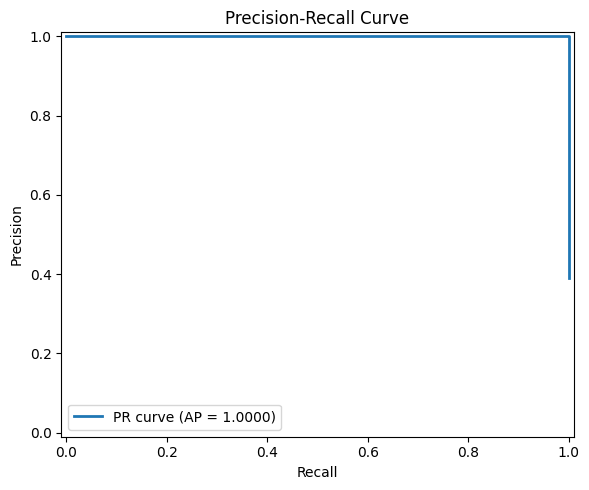


Saved plots to:
 - /kaggle/working/eval_confusion.png
 - /kaggle/working/eval_roc.png
 - /kaggle/working/eval_pr.png


In [15]:
# Cell 12 — evaluation on validation set (with graphs)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
import itertools
import os

# collect predictions
y_true = []
y_probs = []
for images, labels in val_ds.unbatch().batch(64):
    preds = model.predict(images, verbose=0).ravel()
    # ensure shapes are compatible
    y_probs.extend(preds.tolist())
    y_true.extend(labels.numpy().reshape(-1).tolist())

y_true = np.array(y_true).astype(int)
y_probs = np.array(y_probs)
y_pred = (y_probs >= 0.5).astype(int)

# Metrics
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, digits=4)
auc = roc_auc_score(y_true, y_probs)
avg_prec = average_precision_score(y_true, y_probs)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print("ROC AUC:", auc)
print("Average Precision (PR AUC):", avg_prec)

# --- Plot 1: Confusion matrix heatmap ---
fig1, ax1 = plt.subplots(figsize=(4,4))
im = ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title("Confusion Matrix")
tick_marks = np.arange(2)
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_xticklabels(["negative (0)", "positive (1)"])
ax1.set_yticklabels(["negative (0)", "positive (1)"])
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax1.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=14)

ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
fig1.tight_layout()
conf_path = "/kaggle/working/eval_confusion.png"
fig1.savefig(conf_path, bbox_inches='tight', dpi=150)

# --- Plot 2: ROC curve ---
fpr, tpr, _ = roc_curve(y_true, y_probs)
fig2, ax2 = plt.subplots(figsize=(6,5))
ax2.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc:.4f})')
ax2.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='Chance')
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic')
ax2.legend(loc="lower right")
fig2.tight_layout()
roc_path = "/kaggle/working/eval_roc.png"
fig2.savefig(roc_path, bbox_inches='tight', dpi=150)

# --- Plot 3: Precision-Recall curve ---
precision, recall, _ = precision_recall_curve(y_true, y_probs)
fig3, ax3 = plt.subplots(figsize=(6,5))
ax3.plot(recall, precision, lw=2, label=f'PR curve (AP = {avg_prec:.4f})')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curve')
ax3.set_xlim([-0.01, 1.01])
ax3.set_ylim([-0.01, 1.01])
ax3.legend(loc="lower left")
fig3.tight_layout()
pr_path = "/kaggle/working/eval_pr.png"
fig3.savefig(pr_path, bbox_inches='tight', dpi=150)

# Display plots inline
plt.show()

print(f"\nSaved plots to:\n - {conf_path}\n - {roc_path}\n - {pr_path}")


In [16]:

# Cell 13 — inference helper & optional batch predict test folder
from tensorflow.keras.preprocessing import image
import pandas as pd, numpy as np, os

def predict_image(filepath, model, img_size=IMG_SIZE, thresh=0.5):
    img = image.load_img(filepath, target_size=img_size)
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = tf.keras.applications.efficientnet.preprocess_input(arr)
    prob = model.predict(arr)[0][0]
    label = "positive (banned)" if prob >= thresh else "negative"
    return prob, label

TEST_DIR = os.path.join(dataset_root, "test")
if os.path.exists(TEST_DIR):
    preds = []
    for fname in os.listdir(TEST_DIR):
        fpath = os.path.join(TEST_DIR, fname)
        try:
            prob, label = predict_image(fpath, model)
            preds.append({"filename": fname, "probability": float(prob), "label": label})
        except Exception as e:
            print("Skip", fname, "error:", e)
    df = pd.DataFrame(preds)
    df.to_csv("/kaggle/working/predictions.csv", index=False)
    print("Saved predictions to /kaggle/working/predictions.csv")
    display(df.head())
else:
    print("No test folder found at:", TEST_DIR)


No test folder found at: /kaggle/input/alcohol-bottle-detection-devansh-srivastava/dataset/test


In [17]:

# Cell 14 — save final model (explicit)
final_model_path = "/kaggle/working/final_model.h5"
model.save(final_model_path)
print("Saved final model to:", final_model_path)


Saved final model to: /kaggle/working/final_model.h5


In [18]:
# === Safe Fine-tuning Cell (updated) ===
fine_tune_layers = 50
for layer in base_model.layers[:-fine_tune_layers]:
    layer.trainable = False
for layer in base_model.layers[-fine_tune_layers:]:
    layer.trainable = True

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_ft = "/kaggle/working/best_model_finetuned.keras"
callbacks_ft = [
    ModelCheckpoint(checkpoint_ft, monitor="val_loss", mode="min", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=4, mode="min", restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]

with strategy.scope():
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    callbacks=callbacks_ft,
    class_weight=class_weight,
    verbose=1
)

print("Fine-tuning completed. Saved:", checkpoint_ft)


Epoch 1/6
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 49 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 49 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


      5/Unknown 23s 77ms/step - accuracy: 0.8821 - auc: 0.9615 - loss: 0.3703

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1



Epoch 1: val_loss improved from inf to 0.14695, saving model to /kaggle/working/best_model_finetuned.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8829 - auc: 0.9626 - loss: 0.3695 - val_accuracy: 0.9792 - val_auc: 1.0000 - val_loss: 0.1469 - learning_rate: 1.0000e-05
Epoch 2/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8778 - auc: 0.9927 - loss: 0.3342
Epoch 2: val_loss did not improve from 0.14695
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.8799 - auc: 0.9924 - loss: 0.3331 - val_accuracy: 0.9792 - val_auc: 1.0000 - val_loss: 0.1484 - learning_rate: 1.0000e-05
Epoch 3/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9178 - auc: 0.9671 - loss: 0.3258
Epoch 3: val_loss did not improve from 0.14695

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9187 - auc: 0.9680 - loss: 0.3243 - val_accuracy: 0.9792 - val_auc: 1.0000 - val_loss: 0.1500 - learning_rate: 1.0000e-05
Epoch 

In [19]:
# === Cell 1: Upload Image ===
from IPython.display import display
from ipywidgets import FileUpload

uploader = FileUpload(accept="image/*", multiple=False)
display(uploader)

print("Upload an image, then run Cell 2 to predict.")


FileUpload(value=(), accept='image/*', description='Upload')

Upload an image, then run Cell 2 to predict.


In [20]:
# === Cell 2: Predict on Uploaded Image (Kaggle) ===
import io
import numpy as np
import tensorflow as tf
import PIL.Image as Image

# Load model if needed:
# model = tf.keras.models.load_model("/kaggle/working/best_model_finetuned.keras")

class_names = ["negative", "positive"] 

# Kaggle returns uploader.value as a tuple of dicts
if len(uploader.value) == 0:
    print("⚠️ No image uploaded. Please upload in Cell 1.")
else:
    # Extract first uploaded file
    file_info = uploader.value[0]   # <-- fix for Kaggle
    img_bytes = file_info['content']

    # Decode image
    img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
    display(img)

    # Preprocess for EfficientNet
    img_resized = img.resize(IMG_SIZE)
    arr = tf.keras.preprocessing.image.img_to_array(img_resized)
    arr = np.expand_dims(arr, axis=0)
    arr = tf.keras.applications.efficientnet.preprocess_input(arr)

    # Predict
    prob = float(model.predict(arr, verbose=0).ravel()[0])
    pred = 1 if prob >= 0.5 else 0

    print("\n=== Prediction ===")
    print("Class:", class_names[pred])
    print("Probability:", round(prob, 4))


⚠️ No image uploaded. Please upload in Cell 1.
